# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [1]:
!pip install aicrowd-cli > /dev/null 

# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [2]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 218kB/s]


In [4]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
replace inputs/inputs_base.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [5]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [6]:
import numpy as np

class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [7]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [8]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    actions = taxienv._possible_actions
    probs = taxienv._ride_probabilities
    rewards = taxienv._ride_rewards 
    value_grids = []
    done = False
    while not done:
        delta = 1
        while (delta>1e-8):
            delta = 0
            new_values = {s:0 for s in states}
            
            for s in states:
                for iterSP in range(len(states)):
                    iterA = actions[s].index(policy[s])
                    new_values[s] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
                delta = max(delta, abs(values[s]-new_values[s]))
            values = new_values.copy()
        value_grids.append(values.copy())
        #-----------------------------------------------------------------------
        done = True
        new_policy = {s: '0' for s in states}
        for s in states:
            localJ = np.zeros(len(actions[s])) # localJ will hold the expected returns for all actions for the given state
            for iterA in range(len(actions[s])): # Find the max of expected returns over all actions possible in the given state
                for iterSP in range(len(states)):   # iterSP iterates over sPrime
                    localJ[iterA] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
            
            new_policy[s] = actions[s][np.argmax(localJ)]
            if (new_policy[s] != policy[s]):
                done = False
        policy = new_policy.copy()


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Value_Grids": value_grids}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

Text(0.5, 0.98, '$\\gamma$=0.85')

<Figure size 432x288 with 0 Axes>

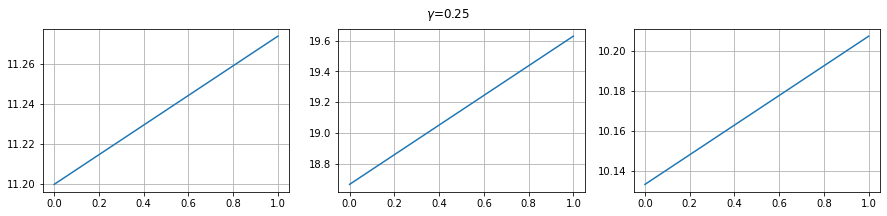

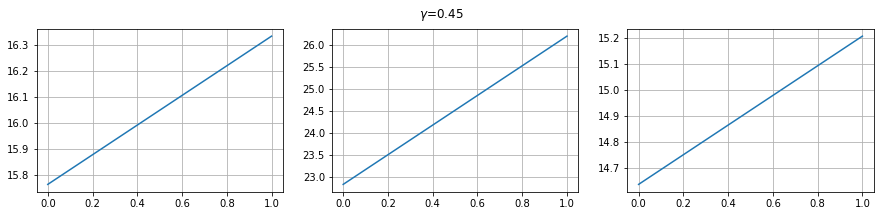

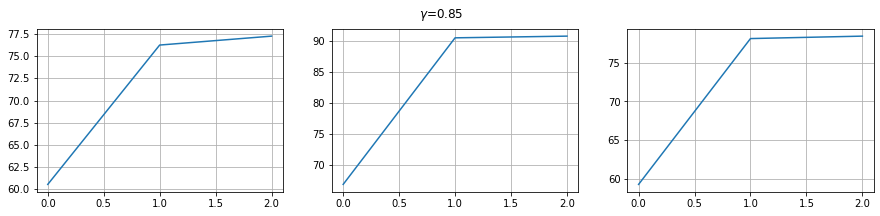

In [9]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

# Plotting the values vs iterations curve for different values of gamma
import matplotlib.pyplot as plt

value_grids = extra_info[0.25]["Value_Grids"]
plt.figure(1)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle("$\gamma$=0.25")

value_grids = extra_info[0.45]["Value_Grids"]
plt.figure(2)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle("$\gamma$=0.45")

value_grids = extra_info[0.85]["Value_Grids"]
plt.figure(3)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle("$\gamma$=0.85")

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [10]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf
    actions = taxienv._possible_actions
    probs = taxienv._ride_probabilities
    rewards = taxienv._ride_rewards 
    value_grids = []
    done = False
    while not done:
        
        for k in range(m):
            new_values = {s:0 for s in states}
            
            for s in states:
                for iterSP in range(len(states)):
                    iterA = actions[s].index(policy[s])
                    new_values[s] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
                
            values = new_values.copy()
        value_grids.append(values.copy())
        #-----------------------------------------------------------------------
        done = True
        new_policy = {s: '0' for s in states}
        for s in states:
            localJ = np.zeros(len(actions[s])) # localJ will hold the expected returns for all actions for the given state
            for iterA in range(len(actions[s])): # Find the max of expected returns over all actions possible in the given state
                for iterSP in range(len(states)):   # iterSP iterates over sPrime
                    localJ[iterA] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
            
            new_policy[s] = actions[s][np.argmax(localJ)]
            if (new_policy[s] != policy[s]):
                done = False
        policy = new_policy.copy()

    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Value_Grids": value_grids}

    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

Text(0.5, 0.98, 'm=10')

<Figure size 432x288 with 0 Axes>

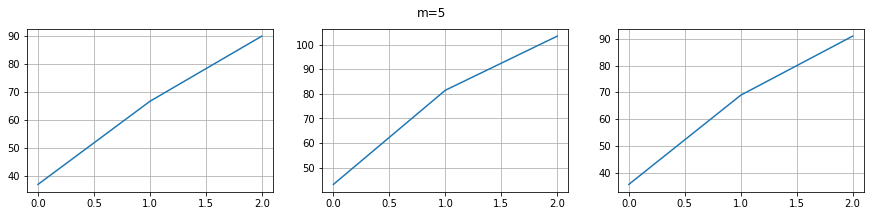

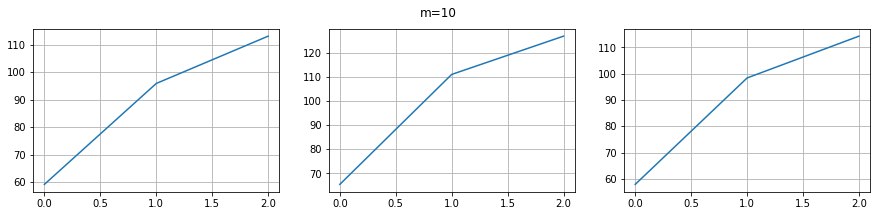

In [11]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

# Plotting the values vs iterations curve for different values of m
import matplotlib.pyplot as plt

value_grids = extra_info[5]["Value_Grids"]
plt.figure(1)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle('m=5')

value_grids = extra_info[10]["Value_Grids"]

plt.figure(2)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle("m=10")

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [12]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf
    actions = taxienv._possible_actions
    probs = taxienv._ride_probabilities
    rewards = taxienv._ride_rewards 
    value_grids = []

    delta = 1
    while (delta>1e-8):
        delta = 0
        new_values = {s:0 for s in states}
        new_policy = {s: '0' for s in states}
        for s in states:
            localJ = np.zeros(len(actions[s])) # localJ will hold the expected returns for all actions for the given state
            for iterA in range(len(actions[s])): # Find the max of expected returns over all actions possible in the given state
                for iterSP in range(len(states)):   # iterSP iterates over sPrime
                    localJ[iterA] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
            
            new_values[s] = max(localJ)
            new_policy[s] = actions[s][np.argmax(localJ)]
            delta = max(delta, abs(values[s]-new_values[s]))
        values = new_values.copy()
        policy = new_policy.copy()
        value_grids.append(values.copy())
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Value_Grids": value_grids}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

Text(0.5, 0.98, 'Value Iteration')

<Figure size 432x288 with 0 Axes>

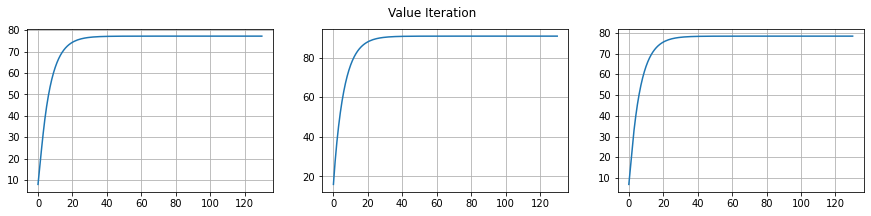

In [13]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)
# Plotting VI for gamma = 0.85
value_grids = extra_info[0.85]["Value_Grids"]
plt.figure(1)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle('Value Iteration')

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [14]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    actions = taxienv._possible_actions
    probs = taxienv._ride_probabilities
    rewards = taxienv._ride_rewards 
    value_grids = []

    delta = 1
    while (delta>1e-8):
        delta = 0
        new_values = values.copy()
        new_policy = policy.copy()
        for s in states:
            localJ = np.zeros(len(actions[s])) # localJ will hold the expected returns for all actions for the given state
            for iterA in range(len(actions[s])): # Find the max of expected returns over all actions possible in the given state
                for iterSP in range(len(states)):   # iterSP iterates over sPrime
                    localJ[iterA] += probs[s][iterA][iterSP]*(rewards[s][iterA][iterSP]+gamma*values[states[iterSP]])
            
            values[s] = max(localJ)
            policy[s] = actions[s][np.argmax(localJ)]
            delta = max(delta, abs(values[s]-new_values[s]))
        value_grids.append(values.copy())
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {"Value_Grids": value_grids}

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

Text(0.5, 0.98, 'Gauss Seidel VI')

<Figure size 432x288 with 0 Axes>

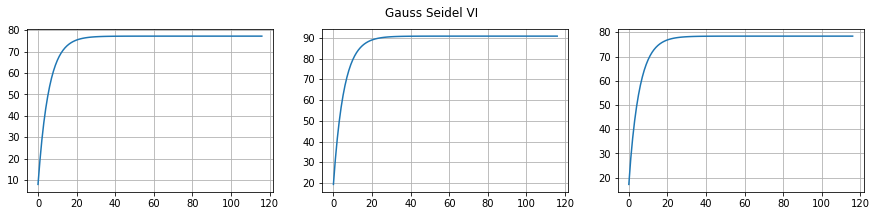

In [15]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)
# Plotting for gamm=0.85
value_grids = extra_info[0.85]["Value_Grids"]
plt.figure(1)
fig,a = plt.subplots(1,3)
index = 0
for s in env.possible_states:
    J = []
    for i in range(len(value_grids)):
        J.append(value_grids[i][s])   
    a[index].plot(J)
    a[index].grid()
    index += 1
fig.set_figheight(3)
fig.set_figwidth(15)
fig.suptitle('Gauss Seidel VI')

# Generate Results ✅

In [16]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [17]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [18]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

In [19]:
## Visualize policy iteration with multiple values of gamma

# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

The taxi will breakdown before the next trip with probability (1-gamma). Therefore, higher the gamma, higher will be the expected reward for the taxi driver. This can be seen in the plots for value vs iterations for different values of gamma.

The value of convergence increases as we increase gamma - this can be seen by plotting the value grids for all states. The number of iterations for convergence is quite small for all gamma but increases for larger gamma.

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

By changing m to 10 from 5, the values on convergence increase - an explanation for this can be that m is the number of iterations of value iteration that we are running and increasing the number of iterations is giving us a better approximation of the optimal value.

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

The plots for VI and Gauss Seidel VI are as below:
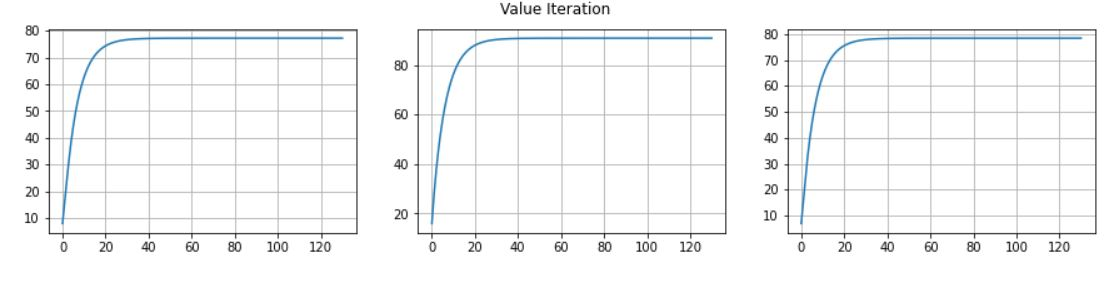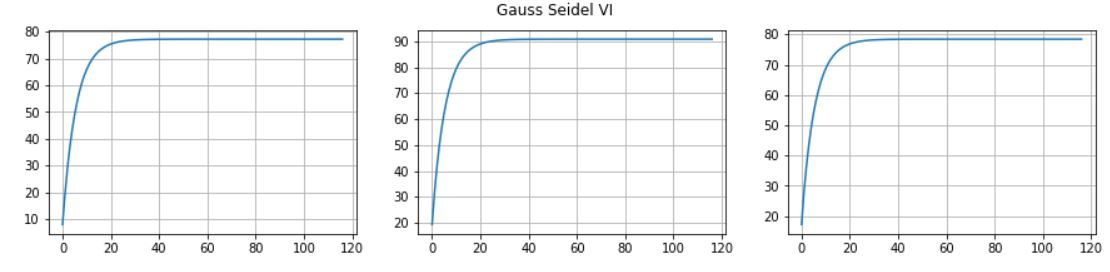

Value Iteration uses the values of the previous iteration (with proper copy) to find the current iteration values whereas Gauss Seidel uses the partially computed values of the current iteration and remaining values of the previous iteration. Ideally, Gauss Seidel should converge slightly faster than VI.

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
